In [343]:
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=1)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [344]:
import numpy as np

def make_score_matrix(seq_a, seq_b, match_score=1, mismatch_score=0 ):
    score_matrix = np.zeros((len(seq_a), len(seq_b)))
    for i, a in enumerate(seq_a):
        for j, b in enumerate(seq_b):
            if a == b:
                score_matrix[i,j] = match_score
            else:
                score_matrix[i,j] = mismatch_score
    return score_matrix

def align_seq(seq_a, seq_b, gap_penalty=-1):
    score_matrix = make_score_matrix(seq_a, seq_b)
    from eden.util.NeedlemanWunsh import needleman_wunsh, trace_back
    needleman_wunsh_matrix = needleman_wunsh(seq_a, seq_b, score_matrix, gap_penalty)
    nw_score = needleman_wunsh_matrix[-1,-1]
    alignment_a, alignment_b = trace_back(seq_a, seq_b, score_matrix, needleman_wunsh_matrix, gap_penalty)
    return alignment_a, alignment_b, nw_score

In [345]:
def select_best_matching(motives, orig_motives):
    for i, orig_motif in enumerate(orig_motives):
        max_score = 0
        max_cluster_id = -1
        max_motif = None
        for motif in motives:
            cluster_id, consensus_seq, trimmed_align_seqs, align_seqs, seqs = motif
            seq_a,seq_b, score = align_seq(orig_motif, consensus_seq)
            if score > max_score:
                max_score = score
                max_cluster_id = cluster_id
                max_motif = motif
        yield max_motif
        
def best_matching_scores(motives, orig_motives):
    for i, orig_motif in enumerate(orig_motives):
        max_score = 0
        max_cluster_id = -1
        max_motif = None
        for motif in motives:
            cluster_id, consensus_seq, trimmed_align_seqs, align_seqs, seqs = motif
            seq_a,seq_b, score = align_seq(orig_motif, consensus_seq)
            score = float(score)/len(orig_motif)
            if score > max_score:
                max_score = score
                max_cluster_id = cluster_id
                max_motif = motif
        yield max_score

In [346]:
import numpy as np
def stable_matching(man_pref_ids, man_pref_vals,
                    woman_pref_ids, woman_pref_vals, 
                    neighbours):
    assert(len(man_pref_ids) == len(man_pref_vals))
    assert(len(woman_pref_ids) == len(woman_pref_vals))

    #print "the number of neighbours are:"
    #print neighbours
    #print type(neighbours)

    # replace value 0 with half of the minimum val that is non zero
    min_val = min(min([x for x in man_pref_vals.flatten() if x > 0]),
                  min([x for x in woman_pref_vals.flatten() if x > 0]))/2
    # use 1/val to convert distances to preferences
    man_pref_dict = dict()

    # make a dict that saves for the combination of a man and woman there preference
    for man_id, (preferred_woman_ids, preferred_woman_vals) in enumerate(zip(man_pref_ids, man_pref_vals)):
        #print preferred_woman_vals
        for preferred_woman_id, preferred_woman_val in zip(preferred_woman_ids, preferred_woman_vals):
            # replace all 0 entrys with the min_val
            if preferred_woman_val == 0:
                preferred_woman_val = min_val
            # print man_id, preferred_woman_val
            man_pref_dict.update({(man_id ,preferred_woman_id):1/float(preferred_woman_val)})
    woman_pref_dict = dict()
    for woman_id, (preferred_man_ids, preferred_man_vals) in enumerate(zip(woman_pref_ids, woman_pref_vals)):
        for preferred_man_id, preferred_man_val in zip(preferred_man_ids, preferred_man_vals):
            if preferred_man_val == 0:
                preferred_man_val = min_val
            woman_pref_dict.update({(woman_id ,preferred_man_id):1/float(preferred_man_val)})

    # initalization of relations: -1 means free
    man_relation_woman = [-1] * len(man_pref_ids)
    woman_relation_man = [-1] * len(woman_pref_ids)

    # initialize position list to store the pointer for the r1_preference_list
    man_pointers = [0] * len(man_pref_ids)
    woman_pointers = [0] * len(woman_pref_ids)

    #for key, value in woman_pref_dict:
        #print key

    counter = 0


    #∃ free man m who still has a woman w to propose to
    while -1 in man_relation_woman:
        counter += 1
        # safeguard against infinite loops
        if counter > 100000:
            print 'Warning: reached max count'
            break
        # if there are no free woman then stop
        if -1 not in woman_relation_man:
            break
        #find free man
        for man_id, proposed_woman_id in enumerate(man_relation_woman):
            if proposed_woman_id == -1:
                #print "current man"
                #print man_id
                break

        #print "man likes woman pointer position:"
        #print man_pointers[man_id]
        #print type(man_pointers[man_id])

        # check if man has a woman to propose to
        if man_pointers[man_id] == neighbours:
            man_relation_woman[man_id] = -2
            continue

        #w = first woman on m’s list to whom m has not yet proposed
        woman_position_in_pref_list = man_pointers[man_id]
        #print "woman_position_in_pref_list"
        #print woman_position_in_pref_list
        man_pref_list = man_pref_ids[man_id]
        woman_id = man_pref_list[woman_position_in_pref_list]
        #print "woman_id"
        #print woman_id

        # if w is free
        if woman_relation_man[woman_id] == -1:
            # (m, w) become engaged
            man_relation_woman[man_id] = woman_id
            woman_relation_man[woman_id] = man_id
            man_pointers[man_id] += 1


            #print "new engaigments"
            #print (man_id, woman_id)

        # else some pair (m', w) already exists
        else:
            current_preferred_man_id = woman_relation_man[woman_id]
            # if w prefers m to m'
            preference_of_new = woman_pref_dict.get((woman_id,man_id),0)
            preference_of_curr = woman_pref_dict.get((woman_id,current_preferred_man_id),0)
            if  preference_of_new >  preference_of_curr:
                # m' becomes free
                man_relation_woman[current_preferred_man_id] = -1
                # (m, w) become engaged
                man_relation_woman[man_id] = woman_id
                woman_relation_man[woman_id] = man_id
                #print "new engaigments"
                #print (man_id, woman_id)
            else:
                # (m', w) remain engaged
                man_pointers[man_id] += 1
                pass
    return (man_relation_woman, woman_relation_man)

In [347]:
% matplotlib inline
import pylab as plt 
import numpy as np
from sklearn.metrics import roc_auc_score

def plot_cumulative_score(smod, pos_seqs, sequence_length=None, motif_length=None):
    sig = None
    for scores in smod.score(pos_seqs):
        if sig is None:
            sig = np.array(scores)
        else:
            sig += np.array(scores)
    sig=np.array(sig)
    
    truth = np.zeros(len(sig))
    truth[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2]=1
    roc = roc_auc_score(truth, sig)
    print 'Cumulative score ROC: %.2f' % roc


    plt.figure(figsize=(16,3))
    sigp = np.copy(sig)
    sigp[sigp<0]=0
    plt.bar(range(len(sigp)), sigp, alpha=0.3, color='g')
    sign = np.copy(sig)
    sign[sign>=0]=0
    plt.bar(range(len(sign)), sign, alpha=0.3, color='r')
    plt.plot((sequence_length/2-motif_length/2, sequence_length/2-motif_length/2), (min(sig), max(sig)), 'k-', lw=4)
    plt.plot((sequence_length/2+motif_length/2, sequence_length/2+motif_length/2), (min(sig), max(sig)), 'k-', lw=4)
    plt.xticks(range(len(sig)))
    plt.grid()
    plt.show()

In [348]:
#code for making artificial dataset
import random
import  numpy as np

def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,perturbation_prob=0.5):
    seq=''
    for c in seed:
        if random.random() < perturbation_prob: 
            c = random.choice(alphabet_list)
        seq += c
    return seq

def create_motives(alphabet='ACGU', motif_length=10):
    motives = []
    for character in alphabet:
        motif = [character]*motif_length
        motives.append(''.join(motif))
    return motives

def make_artificial_dataset(alphabet='ACGU', 
                            motif_length=10,
                            sequence_length=100, 
                            n_sequences=1000, 
                            n_motives=2, 
                            perturbation_prob=0.2):
    alphabet_list=[c for c in alphabet]
    motives = [random_string(motif_length, alphabet_list) for i in range(n_motives)]
        
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences / n_motives

    counter=0
    seqs=[]
    targets=[]
    for i in range(n_seq_per_motif):
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,perturbation_prob)
            seq = left_flanking + noisy_motif + right_flanking
            seqs.append(('ID_%.3d'%counter,seq))
            targets.append(j)
            counter += 1
    return seqs, np.array(targets), motives

In [349]:
motif_length=10
n_motives=2
sequence_length=50
n_sequences=300*n_motives
perturbation_prob=0.2

pos_seqs, targets, orig_motives = make_artificial_dataset('ACGU',motif_length,sequence_length,n_sequences,n_motives,perturbation_prob)

In [350]:
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(pos_seqs, modifier=shuffle_modifier, times=1, order=2)
neg_seqs = list(neg_seqs)

In [351]:
complexity=4
n_clusters=n_motives*5
min_subarray_size=motif_length-motif_length/2
max_subarray_size=motif_length+motif_length/2
block_size=n_sequences/8

In [352]:
print 'motif_length:',motif_length
print 'n_motives:',n_motives
print 'sequence_length:',sequence_length
print 'n_sequences:',n_sequences
print 'perturbation_prob:',perturbation_prob

print 'n_clusters:',n_clusters
print 'min_subarray_size:',min_subarray_size
print 'max_subarray_size:',max_subarray_size
print 'block_size:',block_size

print
for motif in orig_motives: print motif

motif_length: 10
n_motives: 2
sequence_length: 50
n_sequences: 600
perturbation_prob: 0.2
n_clusters: 10
min_subarray_size: 5
max_subarray_size: 15
block_size: 75

ACAGCGGUCG
GUGGCGUUUU


Examples:

Cluster: 0
ACAACGGUCG GCCUGCUUCACAGCCUGGACACAACGGUCGCUAGCCAGGAGCACCGGACU
ACAAGGGCCC UAGUGUGAAGAAGGCACCAAACAAGGGCCCAAACAGGACAUACAGUGGUU
ACAGCGGUCG AUAUUAGAGGGCCCCCAUAGACAGCGGUCGUUUUCAGCGAGUUUAGACGU
ACCGCGGUCC ACUCUACAGCGAAAGCUUUGACCGCGGUCCCGACCUGUUCAGGUGCGAUU
ACGGAGCUCG GAAGAUGGAGUUGCUGGCCAACGGAGCUCGAGAAAAAUCAGGCUGUGGCA
ACAUUGGCCG CUAAUUAACUGAACGGCGACACAUUGGCCGUUAAAACGAGACGAUACUAA
GGAGCGGUAG UAGAUCCCGACCCCACGAAUGGAGCGGUAGUUAAGAGUCAAUCGCUUUUU
ACAUCGGUCC UAUAGGGUUGUAGCGCUUCGACAUCGGUCCAACACUGCGAGAGUUGGAGU

Cluster: 1
GUGGCGUUUU UCUGGUGGAGCGCUACUUAUGUGGCGUUUUAUAGAGGGUCUCUCUCGUAA
GUGGCGUUUU CAACUGGGUGAAUCUCUCCGGUGGCGUUUUCCUUCAGUAAACCUAGAACU
GUGGAGCUUU CUCAAUGUCGUUACAAGUGCGUGGAGCUUUACCGGACGUGUGCGCGAUUA
GUGGCUUUUU ACUCACUGAGCUCUGCAUGGGUGGCUUUUUACGGGGCCCAACUACUCCAA
GUCGCAAUUU AGCCGAAACACAAUAACCCGGUCGCAAUUUUCUUAAUAAAUCAACAGUAU
GUGGCGUUUU UUAUAUUGAUUGUAGGUCAGGUGGCGUUUUACUGACAAACGUACUUCCUU
AUGAGGUUUU UUCGCGGUGCUCUCGAGUGGAUGAGGUUUUAAAGAAGCAGCGUCGAUGAA
GUUGCGUCUU CCCACUCGGCAAGUAGUGAAGUUGC

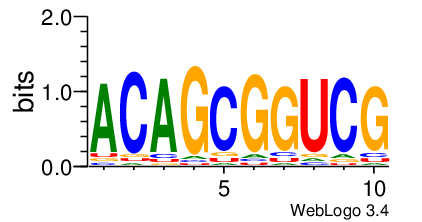

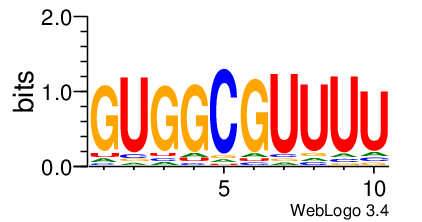

In [353]:
print 'Examples:'

max_chars=100
for id_clus in range(n_motives):
    print 
    print 'Cluster: %d' % id_clus
    for i,( h,s) in enumerate(pos_seqs[:16]):
        id = i % n_motives
        if id == id_clus:
            print s[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2], s[:max_chars]

            
from collections import defaultdict

true_motives = defaultdict(list)
for i,( h,s) in enumerate(pos_seqs):
    id = i % n_motives
    true_motives[id].append((h,s[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2]))
from eden.sequence_motif_decomposer import Weblogo
wl= Weblogo(resolution=200,stacks_per_line=60, sequence_type='rna')

for id in true_motives:
    logo = wl.create_logo(true_motives[id])
    from IPython.display import Image, display
    display(Image(logo))

Cluster id: 4
GACAGCGGUC


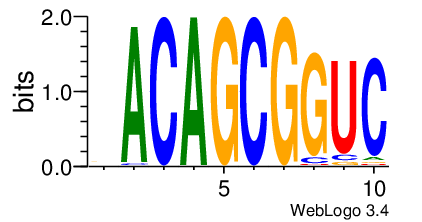

Cluster id: 6
GUGGCGUUUUA


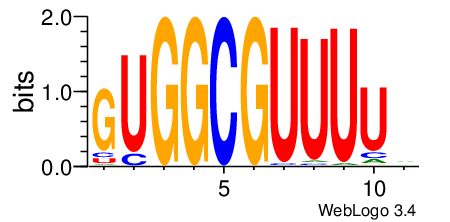

Average score: 0.80


In [354]:
pos_size = len(pos_seqs)
train_pos_seqs = pos_seqs[:pos_size/2]
test_pos_seqs = pos_seqs[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]

from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
smod=SMoD(complexity=complexity,
          n_clusters=n_clusters,
          min_subarray_size=min_subarray_size,
          max_subarray_size=max_subarray_size,
          pos_block_size=block_size,
          neg_block_size=block_size)
smod = smod.fit(train_pos_seqs, train_neg_seqs)
clusters = smod.predict(test_pos_seqs)
motives = smod.compute_motives(clusters,
                               min_score=min_subarray_size,
                               min_freq=0.6,
                               min_cluster_size=(n_sequences/n_motives)/50)
logos = smod.display_logos(select_best_matching(motives, orig_motives))
avg_score = np.mean([s for s in best_matching_scores(motives, orig_motives)])
print 'Average score: %.2f' % avg_score

# Full analysis

Confusion matrix:
[[233  67]
 [121 179]]
Classification:
             precision    recall  f1-score   support

         -1       0.66      0.78      0.71       300
          1       0.73      0.60      0.66       300

avg / total       0.69      0.69      0.68       600

ROC: 0.756
Cumulative score ROC: 1.00


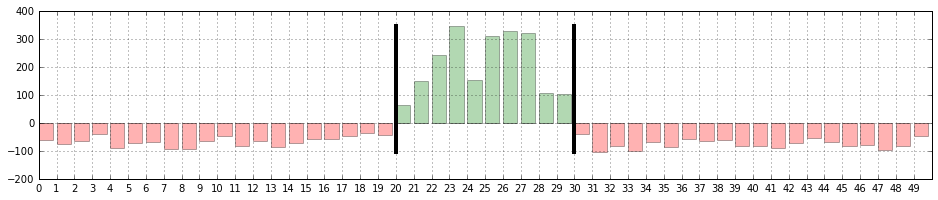

High quality motives
Cluster id: 2
GGCGUUC


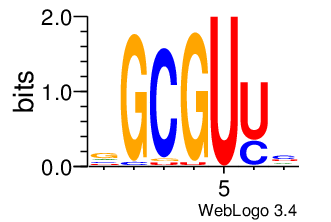

Cluster id: 4
CGGCGGUC


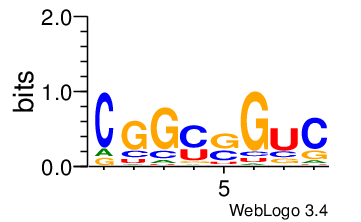

Cluster id: 0
CACAGCGG


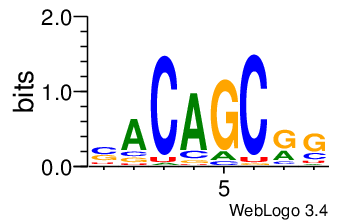

Cluster id: 8
AACAGCGGUC


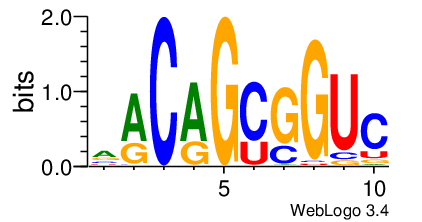

Cluster id: 7
GUGGCGUUUUA


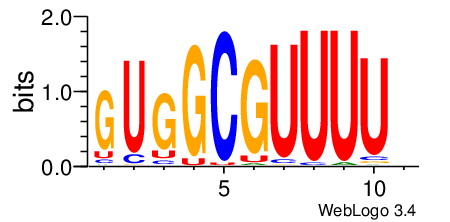

Cluster id: 6
CAGACAGUG


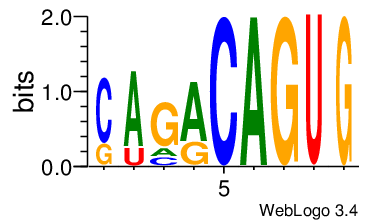

CPU times: user 2.39 s, sys: 418 ms, total: 2.81 s
Wall time: 8.34 s


In [355]:
%%time

pos_size = len(pos_seqs)
train_pos_seqs = pos_seqs[:pos_size/2]
test_pos_seqs = pos_seqs[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]

from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
smod=SMoD(complexity=complexity,
          n_clusters=n_clusters,
          min_subarray_size=min_subarray_size,
          max_subarray_size=max_subarray_size,
          pos_block_size=block_size,
          neg_block_size=block_size)
smod = smod.fit(train_pos_seqs, train_neg_seqs)
smod.performance(test_pos_seqs, test_neg_seqs)
plot_cumulative_score(smod, test_pos_seqs, sequence_length=sequence_length, motif_length=motif_length)
clusters = smod.predict(test_pos_seqs)
motives = smod.compute_motives(clusters,
                               min_score=min_subarray_size,
                               min_freq=0.6,
                               min_cluster_size=(n_sequences/n_motives)/50)
print 'High quality motives'
logos = smod.display_logos(motives)

In [356]:
import pylab as plt
from collections import defaultdict
import numpy as np

def hits(clusters, ids=None):
    for i in ids:
        for h,s in clusters[i]:
            tokens = h.split('*')            
            seq_id = tokens[0]
            begin,end = tokens[1].split(':')
            yield (seq_id, int(begin), int(end), i)

def show_cooccurence(clusters, ids=None):
    if ids is None:
        ids = range(len(clusters))
    seqs_summary = defaultdict(list)
    for seq_id, begin, end, i in hits(clusters, ids=ids):
        seqs_summary[seq_id].append((begin, end, i))

    distances=defaultdict(list)
    cooccurence_mtx=np.zeros((len(clusters),len(clusters)))   
    for seq_id in sorted(seqs_summary):
        cluster_ids = [cluster_id for begin, end, cluster_id in seqs_summary[seq_id]]
        centers = {cluster_id: begin + (end - begin)/2 for begin, end, cluster_id in seqs_summary[seq_id]}
        cluster_ids = set(cluster_ids)
        cluster_ids = list(cluster_ids)
        for i in cluster_ids:
            for j in cluster_ids:
                cooccurence_mtx[i,j]+=1
                if i != j:
                    distances[(i,j)].append(centers[i]-centers[j])
    cooccurence_mtx = np.nan_to_num(cooccurence_mtx)
    cooccurence_list = []
    for i,row in enumerate(cooccurence_mtx):
        norm = row[i]
        if norm != 0:
            row /= norm
        else:
            row = np.zeros(row.shape)
        row[i]=0
        cooccurence_list.append(row)
    norm_cooccurence_mtx=np.vstack(cooccurence_list)

    plt.figure( figsize=(6,6) )
    img = plt.imshow( norm_cooccurence_mtx, interpolation='none', cmap=plt.get_cmap( 'YlOrRd' ) )
    plt.xticks(range(len(norm_cooccurence_mtx)))
    plt.yticks(range(len(norm_cooccurence_mtx)))
    plt.show()
    return cooccurence_mtx, norm_cooccurence_mtx, distances

def show_distances(distances, id_pairs=None, ids=None, nbins=5, size=(6,2)):
    def plot():
        ds = distances[(i,j)]
        print i,j
        plt.figure(figsize=size)
        n, bins, patches = plt.hist(ds, nbins, normed=1, facecolor='green', alpha=0.75)
        plt.grid()
        plt.show()
    for i,j in distances:
        if id_pairs is not None:
            if (i,j) in id_pairs or (j,i) in id_pairs:
                plot()
        if ids is not None:
            if i in ids and j in ids:
                plot()

[2, 4, 0, 8, 7, 6]


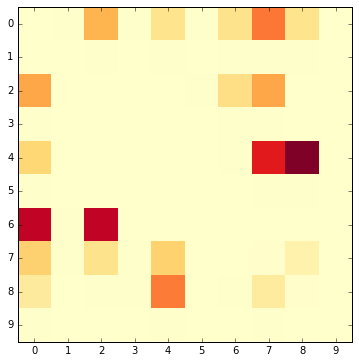

2 7


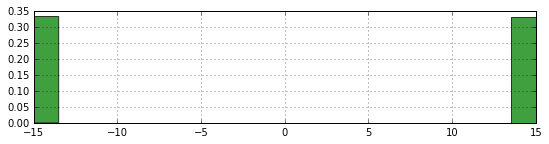

4 7


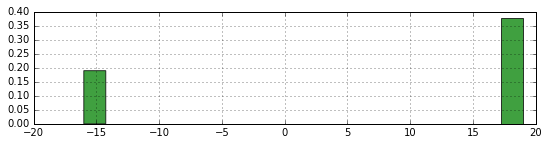

2 6


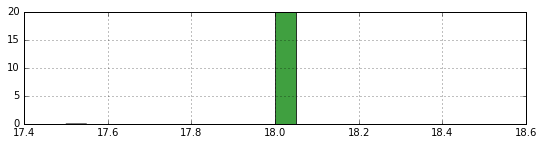

7 0


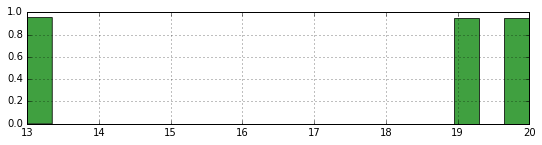

4 8


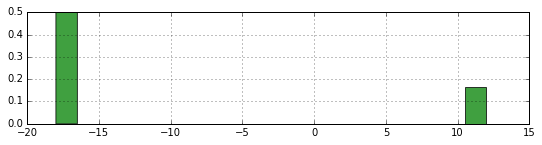

8 0


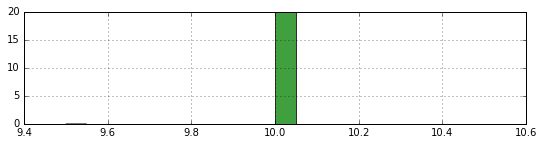

6 0


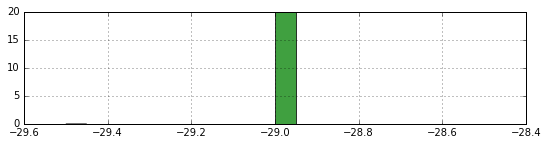

0 7


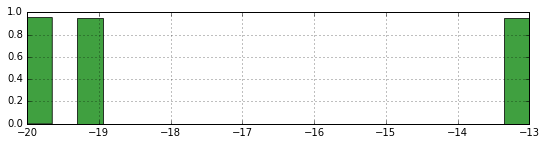

7 4


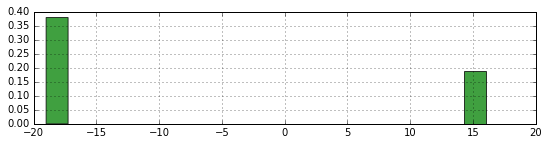

0 6


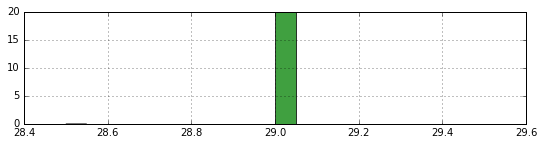

6 2


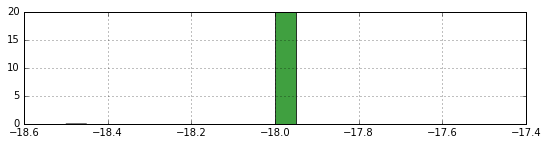

8 7


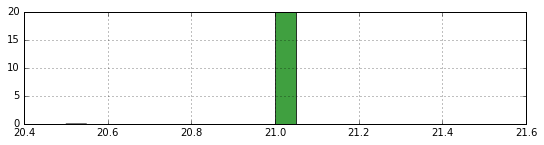

0 4


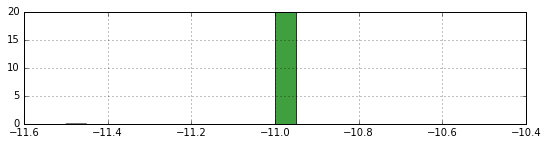

4 0


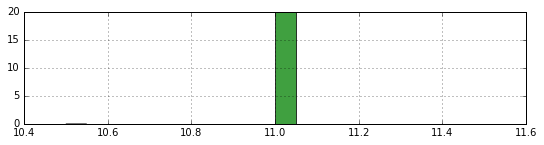

2 0


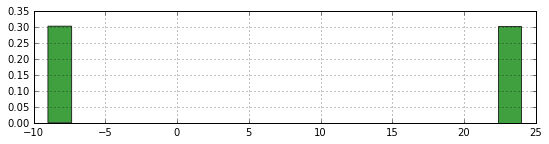

0 8


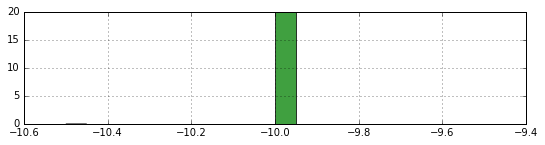

7 8


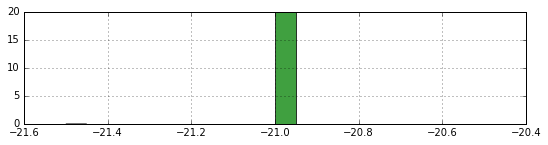

0 2


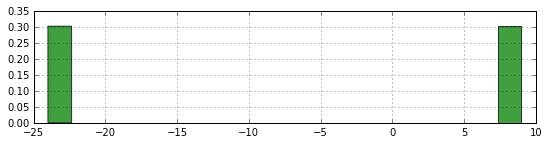

7 2


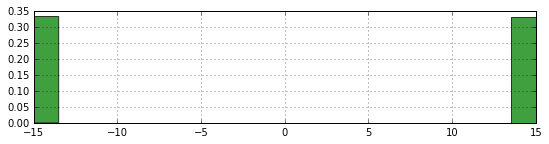

8 4


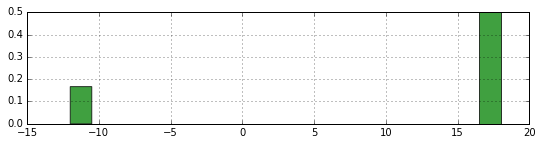

In [357]:
ids = [cluster_id for cluster_id, consensus_seq, trimmed_align_seqs, align_seqs, seqs in motives]
print ids
cooccurence_mtx, norm_cooccurence_mtx, distances = show_cooccurence(clusters, ids=ids)
#id_pairs=[(3,2),(4,5)]
show_distances(distances, id_pairs=None, ids=ids, nbins=20, size=(9,2))

---